# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [26]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import warnings; warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)


**Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.**

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from 
# disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target


In [3]:
# break off
# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the 
# number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a 
# different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) **Create a 10x10 grid to visualize 10 examples of each digit. Python hints:**

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

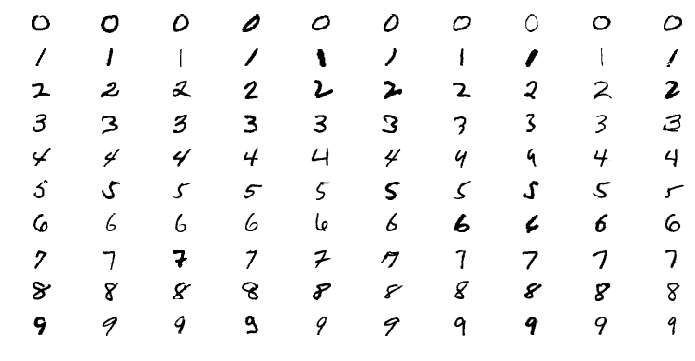

In [4]:
def P1(num_examples=10):

### STUDENT START ###

    plt.figure(figsize=(17, 6))
    fig, axes = plt.subplots(3, 6, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.3, wspace=0.85)
    
    for j in range(num_examples):  # Loop through the digits 0 to 9
        mini_train_rs = mini_train_data[mini_train_labels == j]
        mini_train_rs = np.reshape(np.ravel(
            mini_train_rs[:num_examples,]), (28 * num_examples, 28))
        # for each digit get num_samples images and plot them
        for i in range(num_examples): 
            ax = plt.subplot(num_examples, num_examples, (
                j*num_examples) + i + 1)
            plt.axis("off")
            ax.imshow(mini_train_rs[(i*28):(
                i*28 + 28),], cmap=plt.cm.gray_r, interpolation='nearest')

### STUDENT END ###

P1(10)  

(2) **Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?**

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [5]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1,3,5,7,9]
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(mini_train_data, mini_train_labels) 
    preds = neigh.predict(dev_data)

# calculate accuracy on devtest
    correct = np.sum(preds==dev_labels)
    total = len(dev_labels)
    print('k: {} total: {}  correct: {}  accuracy: {:.3}'.format(
        k, total, correct, 1.0 * correct / total))
    if k==1:
        print(classification_report(dev_labels, preds))   

k: 1 total: 1000  correct: 888  accuracy: 0.888
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

k: 3 total: 1000  correct: 878  accuracy: 0.878
k: 5 total: 1000  correct: 869  accuracy: 0.869
k: 7 total: 1000  correct: 865  accuracy: 0.865
k: 9 total: 1000  correct: 863  accuracy: 0.863


ANSWER: <font color=blue>Based on F1 score, 9 is the most difficult digit. This can have relatively higher false positives and negatives. The precision and recall clearly state it.</font>

(3) **Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.**

- time.time() gives a wall clock value you can use for timing operations

In [6]:
def P3(train_sizes, accuracies):
####
### STUDENT START ###
    k = 1
    # Loop through train sizes
    for ts in train_sizes:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(train_data[:ts,], train_labels[:ts,]) 
        # Measure prediction time
        t0 = time.time()
        preds = neigh.predict(dev_data)
        t1 = time.time()
        elapsed_time = t1 - t0

        # calculate accuracy on devtest
        correct = np.sum(preds==dev_labels)
        total = len(dev_labels)
        accuracies = correct/total * 1.0
        print(
        'Predict time: {:.2} seconds, train sz: {}  correct: {}  accuracy: {:.3}'.format(
            elapsed_time, ts, correct, accuracies))


train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = 0
P3(train_sizes, accuracies)

### STUDENT END ###


Predict time: 0.11 seconds, train sz: 100  correct: 720  accuracy: 0.72
Predict time: 0.23 seconds, train sz: 200  correct: 786  accuracy: 0.786
Predict time: 0.5 seconds, train sz: 400  correct: 841  accuracy: 0.841
Predict time: 1.0 seconds, train sz: 800  correct: 884  accuracy: 0.884
Predict time: 1.9 seconds, train sz: 1600  correct: 902  accuracy: 0.902
Predict time: 4.3 seconds, train sz: 3200  correct: 926  accuracy: 0.926
Predict time: 9.0 seconds, train sz: 6400  correct: 937  accuracy: 0.937
Predict time: 1.7e+01 seconds, train sz: 12800  correct: 959  accuracy: 0.959
Predict time: 3.3e+01 seconds, train sz: 25000  correct: 970  accuracy: 0.97


Answer: <font color=blue>Clearly it can be seen that the prediction time is linearly correlated with the training size. As training size doubles, the prediction time also doubles correspondingly.</font>


(4) **Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?**

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [7]:
def P4(train_data, train_labels):

### STUDENT START ###
    X = train_data
    y = train_labels
    lr = LinearRegression(fit_intercept=True)
    X.shape
    lr.fit(X, y)
    lr.coef_.shape
    preds = lr.predict(X)
    print(preds[:4])
    return preds,y
### STUDENT END ###

predicted_linear, linear_y = P4(train_data, train_labels)

[ 1.60683893  8.4361018   1.57329821  2.55837894]


It can be seen that Linear Regression outputs classes with decimals. This is the challenge of using Linear Regression for classification problems. However, one can overcome this limitation by using a Round function to determine the class. Let's do so and check the accuracy!

In [8]:
print('Linear regression Dev data accuracy = {:.2}'.format(
    np.mean(np.round(predicted_linear) == linear_y)))

Linear regression Dev data accuracy = 0.23


ANSWER: <font color=blue>23% accuracy. Side effect of using thresholds for linear regression!</font>

Linear regression has 2 drawbacks atleast:
> - Sensitive to outliers 

> - Can predict values less than 0 or greater than 9 om this example

To resolve such issues one can use Logistic Regression with L2 
regularization as below:
> What logistics regression does is squashes the output of Linear 
regression between 0 and 1. It transforms the X vector into 1/(1 + exp(-X * theta))

In [9]:
from sklearn import linear_model
logistic_clf =  linear_model.LogisticRegression(
    C=0.5, solver = 'lbfgs', multi_class='multinomial')
logistic_clf.fit(train_data, train_labels)
print(logistic_clf.score(dev_data, dev_labels))

0.934


> <font color=blue> Clearly, you can see how the accuracy improves here to 93.4%. </font>

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix
to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [23]:
def P5(ip_train_data, ip_train_labels, ip_dev_data, ip_dev_labels, ip_suppress_cm="n"):
    ####
    ### STUDENT START ###
    k = 1
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(ip_train_data, ip_train_labels) 
    t0 = time.time()
    predicted = neigh.predict(ip_dev_data)
    t1 = time.time()
    elapsed_time = t1 - t0

    # calculate accuracy on devtest
    correct = np.sum(predicted==ip_dev_labels)
    total = len(ip_dev_labels)
    accuracies = correct/total * 1.0
    print(
    'Predict time: {:.2} seconds, Dev data sz: {}  correct: {}  accuracy: {:.3}'.format(
        elapsed_time, len(ip_dev_data), correct, accuracies))
    if (ip_suppress_cm=="n"):
        print("Confusion matrix:\n%s" % confusion_matrix(ip_dev_labels, predicted))
    return(predicted)
    ### STUDENT END ###

dev_pred = P5(train_data, train_labels, dev_data, dev_labels)


Predict time: 5.8e+01 seconds, Dev data sz: 1000  correct: 980  accuracy: 0.98
Confusion matrix:
[[ 99   0   0   0   0   0   0   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  1   0  99   1   0   0   0   1   0   0]
 [  0   0   0  81   0   2   0   0   1   2]
 [  0   0   0   0 104   0   0   0   0   0]
 [  1   0   0   0   0  88   1   0   0   1]
 [  0   0   0   0   1   0  97   0   0   0]
 [  0   0   1   0   0   0   0 111   0   1]
 [  0   0   1   2   0   1   0   0  92   0]
 [  0   0   0   0   1   1   0   0   0 104]]


Print some examles of the most confused digits

[[ 99   0   0   0   0   0   0   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  1   0  98   2   0   0   0   1   0   0]
 [  0   0   0  83   0   1   0   0   1   1]
 [  0   0   0   0 102   0   0   0   0   2]
 [  1   0   0   0   0  88   0   0   1   1]
 [  1   0   0   0   1   0  96   0   0   0]
 [  0   0   1   0   0   0   0 111   0   1]
 [  1   0   1   2   0   2   1   0  89   0]
 [  0   0   0   0   0   0   0   0   0 106]]

Some of the pairs that were the most confused:
 [[0, 2], [0, 5], [0, 6], [0, 8], [2, 3], [2, 7], [3, 8], [5, 8]]


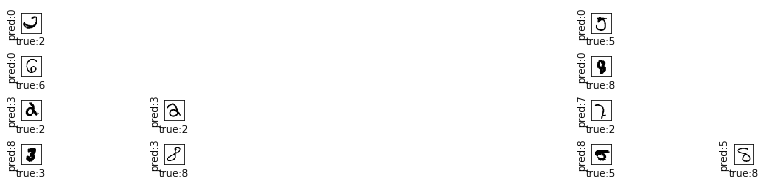

In [11]:
plt.figure(figsize=(20, 6))
plt.subplots_adjust(hspace = 1.2)
cm = confusion_matrix(dev_labels, dev_pred)
print(cm)
# most confused pairs
most_confused = [] # pair holder
m = 0  # mistake holder
for digit1 in range(10):
    for digit2 in range(digit1+1,10):
        confused_num = cm[digit1, digit2] + cm[digit2, digit1]   # count mistakes
        if confused_num > m:
            m = confused_num
            most_confused.append([digit1, digit2])
        elif confused_num == m:
            if m>0:
                most_confused.append([digit1, digit2])
print('\nSome of the pairs that were the most confused:\n', 
          most_confused)
    
# find and plot mistakes
for i, [pair1,pair2] in enumerate(most_confused):
    # get indices where dev_pred == pair1
    idc1 = (dev_pred == pair1)
    # find where pair1 was predicted as pair2
    mixups = []
    for k,val in enumerate(dev_data[idc1]):
        if (dev_labels[idc1])[k]==pair2:
            mixups.append(val)
    cnt = len(mixups)

    # plot formatting
    for j in range(min(cnt,4)):
        ax = plt.subplot(8,8,j+1+(i*4))
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])    
        plt.imshow(mixups[j].reshape(28,28),cmap='gray_r')
        plt.ylabel('pred:%d' %pair1)
        plt.xlabel('true:%d' %pair2)
        
    # get indices where dev_pred==pair2
    idc2 = (dev_pred == pair2)
    # find where pair1 was predicted as pair2
    mixups = []
    for k,val in enumerate(dev_data[idc2]):
        if (dev_labels[idc2])[k]==pair1:
            mixups.append(val)
    cnt = len(mixups)
        
    # plot formatting
    for j in range(min(cnt,4)):
        ax = plt.subplot(8,8,j+1+(i*4))
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])    
        plt.imshow(mixups[j].reshape(28,28),cmap='gray_r')
        plt.ylabel('pred:%d' %pair2)
        plt.xlabel('true:%d' %pair1)
        

(6) **A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.**

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [13]:
from scipy.ndimage.filters import gaussian_filter
def P6():
    
### STUDENT START ###
    blurred_train = gaussian_filter(train_data, sigma=0.25)
    blurred_dev = gaussian_filter(dev_data, sigma=0.25)

    placeholder = P5(
        blurred_train, train_labels, dev_data, dev_labels, ip_suppress_cm="y")
    placeholder = P5(
        train_data, train_labels, blurred_dev, dev_labels, ip_suppress_cm="y")
    placeholder = P5(
        blurred_train, train_labels, blurred_dev, dev_labels, ip_suppress_cm="y")
### STUDENT END ###

P6()



Predict time: 8.4e+01 seconds, Dev data sz: 1000  correct: 977  accuracy: 0.977
Predict time: 7.2e+01 seconds, Dev data sz: 1000  correct: 977  accuracy: 0.977
Predict time: 7.8e+01 seconds, Dev data sz: 1000  correct: 977  accuracy: 0.977


Let's try the manual blurring option and see how it fares!

In [ ]:
# return 0 value if array out of bounds else pixelvalue
def get_pixel_at(pixel_grid, i, j):
    if ( i >= pixel_grid.shape[0] or j >= pixel_grid.shape[1] ):
        return 0   
    elif (i < 0 or j < 0):
        return 0
    else:
        return pixel_grid[i,j]

def test_get_pixel_at():
    ''' Basic, brief sanity checks for get_pixel_at. '''

    # If all of these tests return true, then your solution to
    # get_pixel_at is probably mostly correct. However, passing
    # these tests does not mean your solution is completely 
    # correct. There are many ways to implement get_pixel_at 
    # that pass these tests and are still wrong. 

    test_grid = np.array([
        [1, 2, 3, 4, 5, 6],
        [0, 2, 4, 6, 8, 10],
        [3, 4, 5, 6, 7, 8]
    ])

    try:
        assert get_pixel_at(
            test_grid, 0, 0) == 1,      "Call to get_pixel_at(0, 0) should have returned 1."
        assert get_pixel_at(
            test_grid, -25, -25) == 0,  "Call to get_pixel_at(-1, 0) should have returned 0."
        assert get_pixel_at(
            test_grid, 0, -1) == 0,     "Call to get_pixel_at(0, -1) should have returned 0."
        assert get_pixel_at(
            test_grid, 2, 5) == 8,      "Call to get_pixel_at(2, 5) should have returned 8."
        assert get_pixel_at(
            test_grid, 3, 5) == 0,      "Call to get_pixel_at(3, 5) should have returned 0."
        assert get_pixel_at(
            test_grid, 2, 6) == 0,      "Call to get_pixel_at(2, 6) should have returned 0."
        assert get_pixel_at(
            test_grid, 3, 6) == 0,      "Call to get_pixel_at(3, 6) should have returned 0."
        assert get_pixel_at(
            test_grid, 1, 3) == 6,      "Call to get_pixel_at(1, 3) should have returned 6."
    except AssertionError as e:
        # Print out a user-friendly error message
        print(e)
        print('hi')

# Run the tests. This method prints nothing if the tests
# pass. This method prints an error message for the first 
# error it encounters.
def average_of_surrounding(pixel_grid, i, j):
    '''
    Returns the unweighted average of the values of the pixel at row i 
    and column j and the eight pixels surrounding it.
    '''
    pixel_sum = 0.0
    endi = pixel_grid.shape[0] - 1
    endj = pixel_grid.shape[1] - 1
    
    top_lefti = i - 1
    top_leftj = j - 1
    
    for counteri in range(top_lefti, top_lefti + 3):
        for counterj in range(top_leftj, top_leftj + 3):
            pixel_sum = pixel_sum + get_pixel_at(pixel_grid, counteri, counterj)

    return pixel_sum / 9

def test_average_of_surrounding():
    ''' Basic, brief sanity checks for average_of_surrounding. '''

    # Similarly to test_get_pixel_at, passing all of these tests
    # does not guarantee that your implementation of 
    # average_of_surrounding is correct.

    test_grid = np.array([
        [9, 9, 9, 9],
        [0, 9, 9, 9],
        [0, 0, 6, 3]
    ])

    try:
        assert average_of_surrounding(
            test_grid, 0, 0) == 3, "Call to average_of_surrounding(test_grid, 0, 0) should have returned 3."
        assert average_of_surrounding(
            test_grid, 0, 3) == 4, "Call to average_of_surrounding(test_grid, 0, 0) should have returned 7."
        assert average_of_surrounding(
            test_grid, 2, 3) == 3, "Call to average_of_surrounding(test_grid, 2, 5) should have returned 7."
    except AssertionError as e:
        print(e)

def blur(pixel_grid):
    '''
    Given pixel_grid (a grid of pixels), returns a new grid of pixels
    that is the result of blurring pixel_grid. In the output grid, 
    each pixel is the average of that pixel and its eight neighbors in
    the input grid. 
    '''
    last_row = pixel_grid.shape[0]
    last_column = pixel_grid.shape[1]
    blurred_grid = pixel_grid
    
    for i in range(last_row):
        for j in range(last_column):
            blurred_grid[i,j] = average_of_surrounding(pixel_grid,i,j)
            
    return blurred_grid
    
def test_blur():
    ''' Basic, brief sanity checks for average_of_surrounding. '''

    # Similarly to test_get_pixel_at, passing all of these tests
    # does not guarantee that your implementation of 
    # average_of_surrounding is correct.

    test_grid = np.array([
        [10, 10, 10, 10],
        [10, 10, 10, 10],
        [10, 10, 10, 10]
    ])

    print(blur(test_grid))

test_grid = np.array([
        [10, 10, 10, 10],
        [10, 10, 10, 10],
        [10, 10, 10, 10]
    ])

 
# Reshape all the data into matrices
test_average_of_surrounding()
train_data_matrix = np.reshape(train_data, ( train_data.shape[0] * 28, 28))

mini_train_data_matrix = np.reshape(mini_train_data, ( 
    mini_train_data.shape[0] * 28, 28))

dev_data_matrix = np.reshape(dev_data, ( dev_data.shape[0] * 28, 28))

test_data_matrix = np.reshape(test_data, ( test_data.shape[0] * 28, 28))


blurred_mini_train_data_matrix = blur(mini_train_data_matrix) 
blurred_mini_train = np.reshape(blurred_mini_train_data_matrix, (
    mini_train_data.shape[0], mini_train_data.shape[1]))

blurred_train_data_matrix = blur(train_data_matrix) 
blurred_train_data = np.reshape(blurred_train_data_matrix, (
    train_data.shape[0], train_data.shape[1]))

blurred_dev_data_matrix = blur(dev_data_matrix)
blurred_dev_data = np.reshape(blurred_dev_data_matrix, 
                              (dev_data.shape[0], dev_data.shape[1]))

# Call KNN with the 3 variants
placeholder = P5(
 blurred_train_data, train_labels, dev_data,         dev_labels, ip_suppress_cm="y")
placeholder = P5(
 train_data,         train_labels, blurred_dev_data, dev_labels, ip_suppress_cm="y")
placeholder = P5(
 blurred_train_data, train_labels, blurred_dev_data, dev_labels, ip_suppress_cm="y")





ANSWER: <font color=blue>Clearly it can be seen that manually implemented Gaussian blur increase the accuracy by 0.3%</font>

(7) **Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?**

In [15]:
def P7():
### STUDENT START ###
    clf = BernoulliNB(alpha = 0.001, binarize = 0.5)
    clf = clf.fit(train_data, train_labels)
    print('Bernoulli Naive Bayes accuracy on dev data : ', clf.score(
        dev_data, dev_labels))
    return clf

BNB_clf = P7()
### STUDENT END ###

Bernoulli Naive Bayes accuracy on dev data :  0.814


Naive Bayes assumes features are independent. This assumption is very strong and rarely the case in real world scenarios. With images, neighboring pixels are almost always dependent, and hence independence is not assured. That said, it is not surprising that the Naive Bayes is able to provide only 85% accuracy while the others are able to provide over 90%

Let's use the multinomial NB

In [16]:
def P72():
### STUDENT START ###
    clf = MultinomialNB(alpha = 1)
    clf = clf.fit(train_data, train_labels)
    print('Multinomial Naive Bayes accuracy on dev data : ', clf.score(
        dev_data, dev_labels))
    return clf
### STUDENT END ###

MNB_clf = P72()


Multinomial Naive Bayes accuracy on dev data :  0.794


The Multinomial NB does notI tried cutting the X features into 3 classes, but I received errors that boundaries cannot overlap. Especially with images, some feature columns have 0 for all the rows. If this is the case, it cannot be split technically in Python. Whereas this limitation is not there in R. Also when there is a feature with aa value of 0.5 for all the rows, to which class should be it be assigned? It is because of these challenges, I used a pure vanilla Multinomial classifier.

ANSWER: The accuracy is comparable to Bernoulli

(8) **Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?**

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [27]:
from sklearn import grid_search
def P8(alphas):

### STUDENT START ###
    BNB = grid_search.GridSearchCV(BernoulliNB(), alphas)
    BNB.fit(dev_data, dev_labels)
    for i in range(8):
        print (BNB.grid_scores_[i])
    
    return BNB
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
warnings.simplefilter('ignore')

mean: 0.09900, std: 0.00074, params: {'alpha': 0.0}
mean: 0.11300, std: 0.00068, params: {'alpha': 0.0001}
mean: 0.11300, std: 0.00068, params: {'alpha': 0.001}
mean: 0.11300, std: 0.00068, params: {'alpha': 0.01}
mean: 0.11300, std: 0.00068, params: {'alpha': 0.1}
mean: 0.11300, std: 0.00068, params: {'alpha': 0.5}
mean: 0.11300, std: 0.00068, params: {'alpha': 1.0}
mean: 0.11300, std: 0.00068, params: {'alpha': 2.0}


In [18]:
#print nb.best_params_
print ("best estimator is %s" % nb.best_estimator_)
print ("best score is %s" % nb.best_score_)
print ("best parameter is %s" % nb.best_params_)

best estimator is BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)
best score is 0.113
best parameter is {'alpha': 0.0001}


ANSWER: <font color=blue>The best value for alpha is 0.0001 based on dev data. Accuracy is 9.8% when alpha = 0. </font>

(9) **Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.**

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [19]:
from sklearn.preprocessing import Normalizer
def P9():

### STUDENT END ###
    clf = GaussianNB()
    clf.fit(train_data, train_labels)
    print('accuracy on dev data : ', clf.score(dev_data, dev_labels))
    return clf

### STUDENT END ###
def P91(threshold):

    scaler = Normalizer().fit(train_data)
    train_data01 = scaler.transform(train_data)
    dev_data01   = scaler.transform(dev_data)
### STUDENT END ###
    clf = GaussianNB()
    clf.fit(train_data01, train_labels)
    print('accuracy on dev data : ', clf.score(dev_data01, dev_labels))
    return clf

### STUDENT END ###

gnb_clf = P9()
gnb2_clf = P91(0.9)


    


accuracy on dev data :  0.628
accuracy on dev data :  0.656


ANSWER:

(10) **Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?**

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

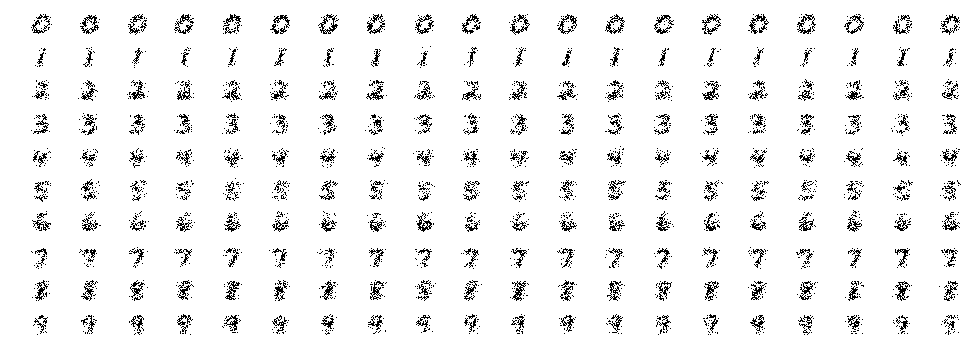

In [20]:
def P10(num_examples):

### STUDENT START ###
    plt.figure(figsize=(17, 6))
    for digit in range(10):
        for no_of_images in range(num_examples):
            mat = np.exp(BNB_clf.feature_log_prob_[digit])
            for k,pix in enumerate(mat):
                n = np.random.rand()
                if pix > n:
                    mat[k] = 1
                else:
                    mat[k] = 0
            ax = plt.subplot(10,20, digit*20+no_of_images+1)
            off = ax.set_axis_off()
            p = plt.imshow(mat.reshape(28,28), cmap='gray_r')

num_examples = 20
P10(num_examples)

### STUDENT END ###


ANSWER: For each pixel in each image, I choose a random number between 0 and 1 from a Uniform distribution; if the probability of this pixel is greater than the random number then I assign it a value 1 otherwise 0. With such an algorithm, I've plotted 20 samples of each digit above.


(11) **Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.**

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [21]:
def myBernoulliNB():
### STUDENT START ###
    clf = BernoulliNB(alpha = 0.001, binarize = 0.5)
    clf = clf.fit(train_data, train_labels)
    dev_pred = clf.predict(dev_data)
    correct  = dev_pred == dev_labels
    accuracy = np.mean(correct)
    print('accuracy on dev data : ', accuracy)
    return clf, correct

myBNB_clf, result = myBernoulliNB()

### STUDENT END ###

def P11(buckets, correct, total):
    
### STUDENT START ###
    # Get the maximum probabilities for each row in dev data
    # and store them as an array
    max_probs = np.amax(myBNB_clf.predict_proba(dev_data), axis=1)
    sorted_result = sorted(range(len(max_probs)),key=lambda x:max_probs[x])   
    max_probs_sorted = sorted(max_probs)
    count = 0
    jcounter = 0
    
    for j in max_probs_sorted:
        count = 0
        for i in range(len(buckets)):
            if (j <= buckets[i]):
                total[count] += 1
                correct[count] += result[sorted_result[jcounter]]
            count += 1
        jcounter += 1
            
 ## STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

accuracy on dev data :  0.814
p(pred) <= 0.5000000000000    total =   3    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  63    accuracy = 0.381
p(pred) <= 0.9990000000000    total = 144    accuracy = 0.431
p(pred) <= 0.9999900000000    total = 234    accuracy = 0.521
p(pred) <= 0.9999999000000    total = 330    accuracy = 0.597
p(pred) <= 0.9999999990000    total = 405    accuracy = 0.640
p(pred) <= 0.9999999999900    total = 463    accuracy = 0.650
p(pred) <= 0.9999999999999    total = 552    accuracy = 0.694
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.814


ANSWER: Clearly at or below 50% posterior probability, the accuracy in only 33.3%. At around 90% posterior probability the accuracy is 55%. It hits a high 85% accuracy at posterior probability of below 1. So, we can say that this one is a weakly calibrated classifier.


(12) **EXTRA CREDIT**

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [22]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()